In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("teen_phone_addiction_dataset_noisy.csv")

print(df.shape)
print(df.info())
print(df.describe(include="all").T.head(10))


(3000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3000 non-null   int64  
 1   Name                    3000 non-null   object 
 2   Age                     3000 non-null   float64
 3   Gender                  3000 non-null   object 
 4   Location                2910 non-null   object 
 5   School_Grade            3000 non-null   object 
 6   Daily_Usage_Hours       3000 non-null   float64
 7   Sleep_Hours             3000 non-null   float64
 8   Academic_Performance    3000 non-null   float64
 9   Social_Interactions     3000 non-null   float64
 10  Exercise_Hours          3000 non-null   float64
 11  Anxiety_Level           3000 non-null   float64
 12  Depression_Level        3000 non-null   float64
 13  Self_Esteem             2910 non-null   float64
 14  Parental_Control        3000 

In [3]:
df.isnull().sum()

ID                         0
Name                       0
Age                        0
Gender                     0
Location                  90
School_Grade               0
Daily_Usage_Hours          0
Sleep_Hours                0
Academic_Performance       0
Social_Interactions        0
Exercise_Hours             0
Anxiety_Level              0
Depression_Level           0
Self_Esteem               90
Parental_Control           0
Screen_Time_Before_Bed     0
Phone_Checks_Per_Day       0
Apps_Used_Daily            0
Time_on_Social_Media       0
Time_on_Gaming             0
Time_on_Education         90
Phone_Usage_Purpose        0
Family_Communication      90
Weekend_Usage_Hours        0
Addiction_Level           90
dtype: int64

In [4]:
# ---------- Step 1: Load dataset ----------
import pandas as pd

df = pd.read_csv("teen_phone_addiction_dataset_noisy.csv")

# Strip spaces from string/object columns
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()

# ---------- Step 2: Handle Gender ----------
# Nominal variable → One-hot encoding
# (keeps "Female" as baseline if drop_first=True)
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# ---------- Step 3: Handle School_Grade ----------
# Ordinal mapping (7th → 7, ..., 12th → 12)
grade_map = {'7th':7, '8th':8, '9th':9, '10th':10, '11th':11, '12th':12}
df['School_Grade'] = df['School_Grade'].map(grade_map)

# ---------- Step 4: Handle Phone_Usage_Purpose ----------
# Nominal variable → One-hot encoding
df = pd.get_dummies(df, columns=['Phone_Usage_Purpose'], drop_first=True)

# ---------- Step 5: Handle Location ----------
# High-cardinality text → Factorize (numeric codes)
df['Location'] = df['Location'].fillna('Unknown')
df['Location'], location_index = pd.factorize(df['Location'])

# ---------- Step 6: Handle Name ----------
# Too unique → Drop it
df = df.drop(columns=['Name'])

# ---------- Step 7: Summary ----------
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                3000 non-null   int64  
 1   Age                               3000 non-null   float64
 2   Location                          3000 non-null   int64  
 3   School_Grade                      3000 non-null   int64  
 4   Daily_Usage_Hours                 3000 non-null   float64
 5   Sleep_Hours                       3000 non-null   float64
 6   Academic_Performance              3000 non-null   float64
 7   Social_Interactions               3000 non-null   float64
 8   Exercise_Hours                    3000 non-null   float64
 9   Anxiety_Level                     3000 non-null   float64
 10  Depression_Level                  3000 non-null   float64
 11  Self_Esteem                       2910 non-null   float64
 12  Parent

<Axes: >

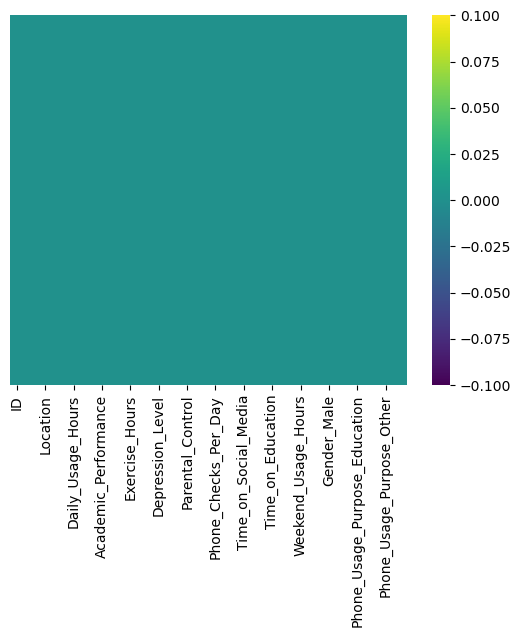

In [5]:
# ---------- Handle missing values ----------

# Drop missing target values (Addiction_Level)
df = df.dropna(subset=['Addiction_Level'])

# Impute numerical features (with mean ± std random values)
num_cols = ['Self_Esteem', 'Time_on_Education', 'Family_Communication']

for col in num_cols:
    avg = df[col].mean()
    std = df[col].std()
    count = df[col].isnull().sum()
    if count > 0:
        random = np.random.uniform(avg - std, avg + std, size=count)
        df.loc[df[col].isnull(), col] = random

# Visualize nulls after imputation
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')


In [6]:
# Select only numerical columns for outlier treatment
numerical_cols = df.select_dtypes(include=np.number).columns

# Cap outliers using the IQR method
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

# Check the result - notice the 'max' values are now more reasonable
print("Descriptive statistics after handling outliers:")
print(df.describe())

Descriptive statistics after handling outliers:
                ID          Age     Location  School_Grade  Daily_Usage_Hours  \
count  2910.000000  2910.000000  2910.000000   2910.000000        2910.000000   
mean   1502.230584    16.045450  1140.947766      9.512715           5.053181   
std     865.828763     2.099568   719.843070      1.710485           2.005813   
min       1.000000    13.000000     0.000000      7.000000           0.000000   
25%     753.250000    14.064410   514.250000      8.000000           3.718008   
50%    1501.500000    15.997322  1103.500000      9.000000           4.998915   
75%    2251.750000    17.932079  1753.750000     11.000000           6.390097   
max    3000.000000    23.733582  2460.000000     12.000000          10.398229   

       Sleep_Hours  Academic_Performance  Social_Interactions  Exercise_Hours  \
count  2910.000000           2910.000000          2910.000000     2910.000000   
mean      6.522554             75.256871             5.14609

In [7]:
from sklearn.preprocessing import StandardScaler

# We don't want to scale our target variable, so we separate it first
X = df.drop('Addiction_Level', axis=1)
y = df['Addiction_Level']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first 5 rows of the scaled data
print("\nFirst 5 rows of scaled data:")
print(X_scaled.head())


First 5 rows of scaled data:
         ID       Age  Location  School_Grade  Daily_Usage_Hours  Sleep_Hours  \
0 -1.734163 -1.436322 -1.585268     -0.299800          -0.464228    -0.267254   
1 -1.733008  0.405438 -1.583878     -1.469260           0.256345    -0.017473   
2 -1.731853 -1.415201 -1.582489      0.869660           0.468297    -0.631065   
3 -1.730698  0.975660 -1.581099      1.454391          -1.049430    -1.697501   
4 -1.729543 -1.066845 -1.579710     -0.299800          -1.286054    -0.029707   

   Academic_Performance  Social_Interactions  Exercise_Hours  Anxiety_Level  \
0              0.180727            -0.044874       -1.243133       1.483875   
1             -0.412224            -0.044874       -1.377700      -0.889847   
2              1.168977             0.876627       -0.298600      -1.228951   
3              0.114843             0.876627        0.775580       1.144771   
4             -1.202824            -0.352041        0.093165      -1.568054   

   ...  

C:\Users\deogh\AppData\Local\Temp\ipykernel_7104\2682392384.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.School_Grade.replace(['7th','8th','9th','10th','11th','12th'], [7, 8, 9, 10, 11, 12], inplace=True)
C:\Users\deogh\AppData\Local\Temp\ipykernel_7104\2682392384.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_s

Correlations with Addiction_Level:
Addiction_Level                     1.000000
Daily_Usage_Hours                   0.566424
Time_on_Social_Media                0.296551
Apps_Used_Daily                     0.294749
Time_on_Gaming                      0.257018
Phone_Checks_Per_Day                0.224207
Phone_Usage_Purpose_Other           0.027246
Age                                 0.019631
Academic_Performance                0.015377
Phone_Usage_Purpose_Gaming          0.013269
Screen_Time_Before_Bed              0.011352
Location                            0.010600
School_Grade                        0.008623
Depression_Level                    0.007866
Anxiety_Level                       0.007107
Family_Communication                0.001136
Gender_Male                        -0.002887
Weekend_Usage_Hours                -0.008417
Time_on_Education                  -0.009737
Phone_Usage_Purpose_Education      -0.010380
Parental_Control                   -0.013453
Social_Interactions 

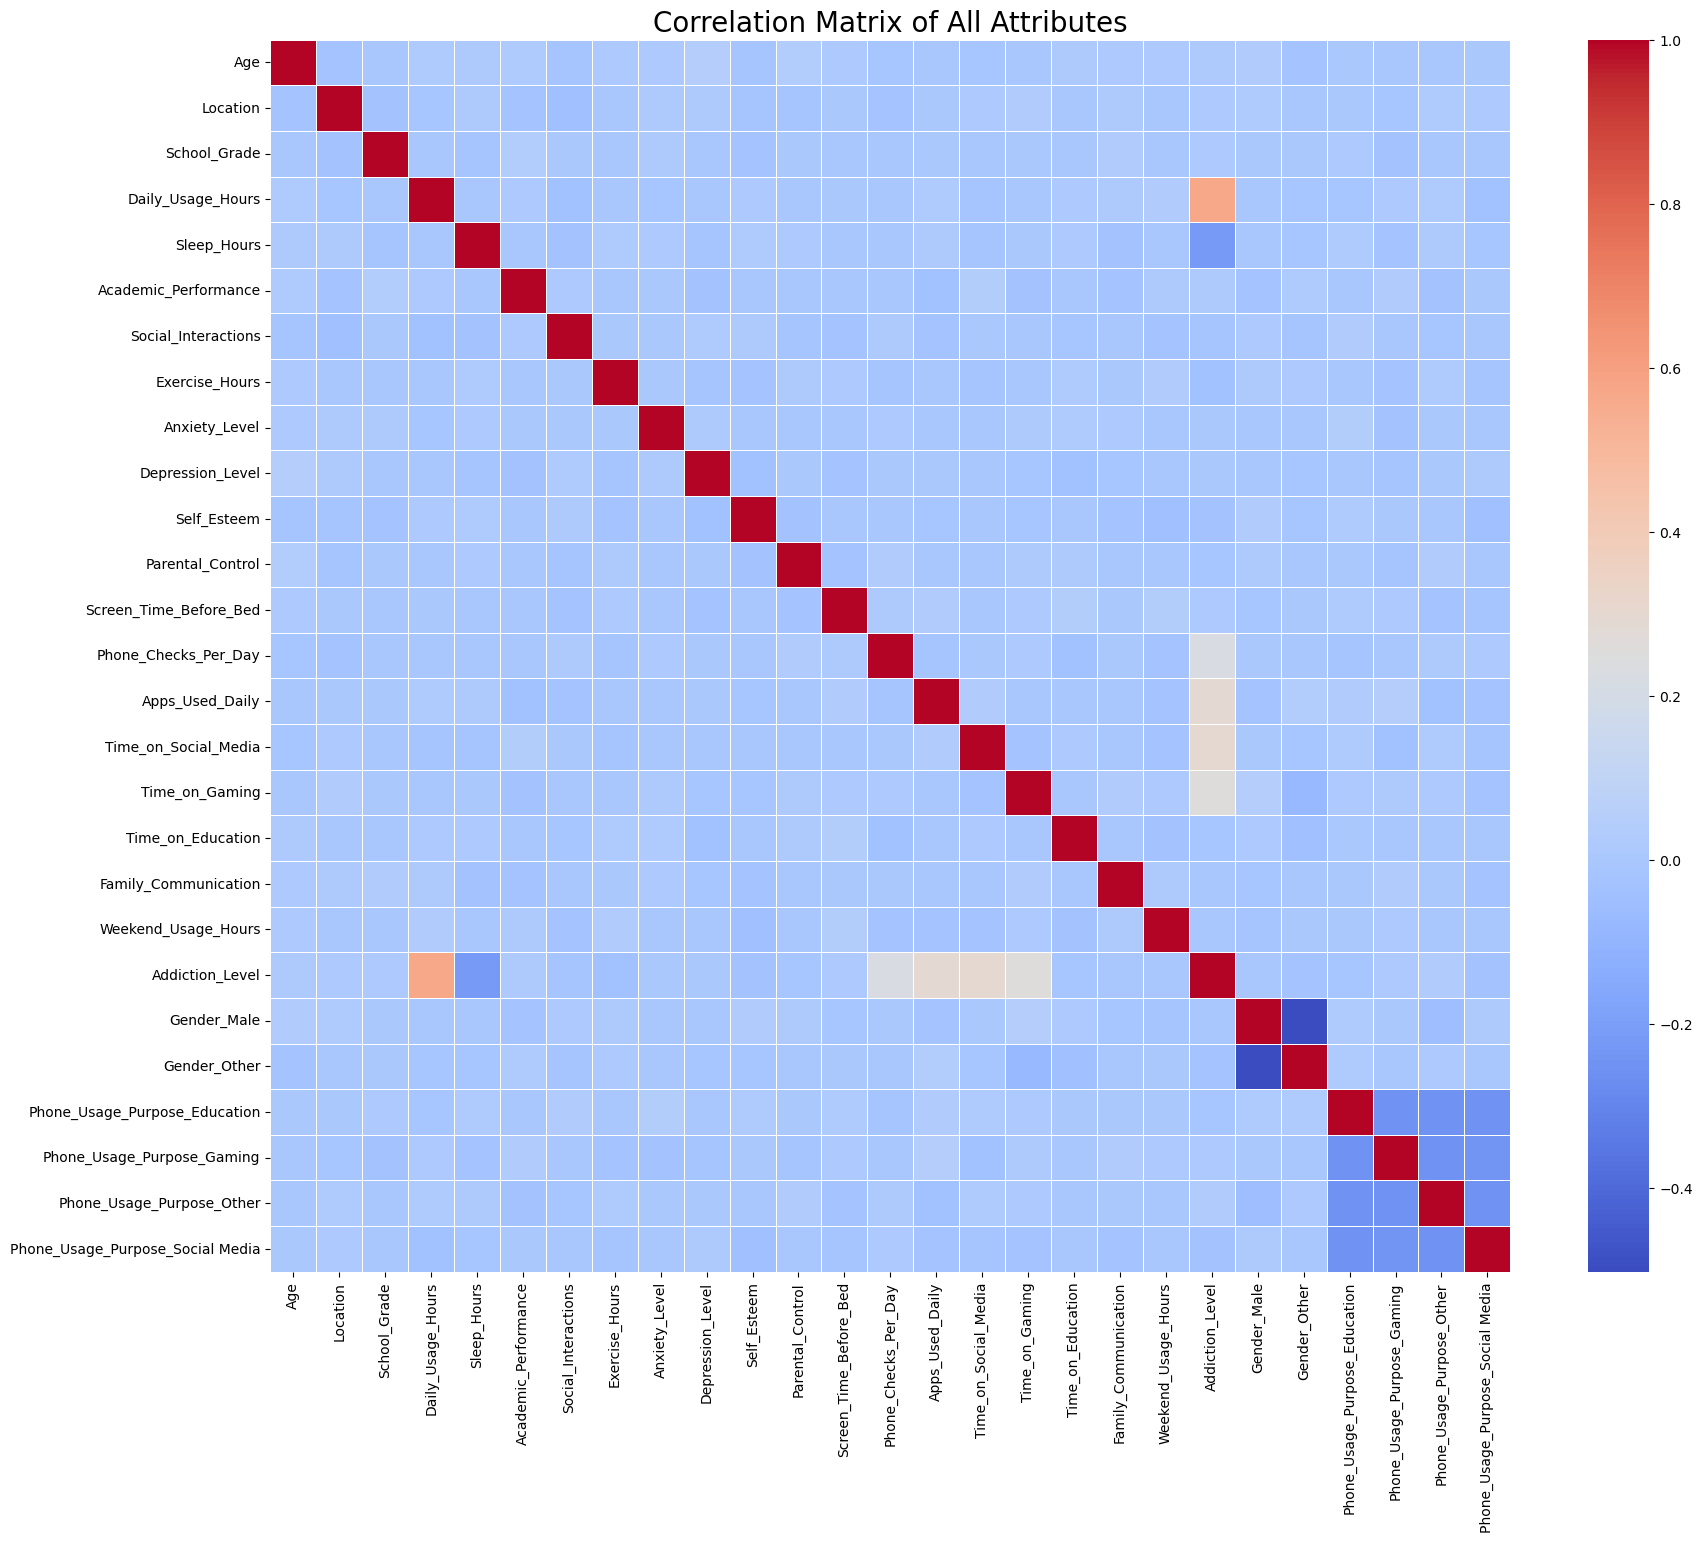

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# In the last step, X_scaled and y were created. I need to recreate the state of 'df'
# before scaling to get an interpretable correlation matrix.
# I will use the user's uploaded file and replicate the preprocessing steps.

# Load data
df = pd.read_csv('teen_phone_addiction_dataset_noisy.csv')

# Preprocessing from previous steps
# 1. Strip whitespace
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()

# 2. Ordinal and Label Encoding (simplified version of user's code)
df.School_Grade.replace(['7th','8th','9th','10th','11th','12th'], [7, 8, 9, 10, 11, 12], inplace=True)
df['Location'], _ = pd.factorize(df['Location'].fillna('Unknown'))
df = df.drop(['ID', 'Name'], axis=1) # Dropping as per suggestion

# One-hot encode as per suggestion
df = pd.get_dummies(df, columns=['Gender', 'Phone_Usage_Purpose'], drop_first=True)

# 3. Handle missing values
df = df.dropna(subset=['Addiction_Level'])
num_cols_to_impute = ['Self_Esteem', 'Time_on_Education', 'Family_Communication']
for col in num_cols_to_impute:
    avg = df[col].mean()
    std = df[col].std()
    count = df[col].isnull().sum()
    if count > 0:
        random = np.random.uniform(avg - std, avg + std, size=count)
        df.loc[df[col].isnull(), col] = random

# 4. Handle Outliers
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

# Now 'df' is fully preprocessed before scaling, which is ideal for correlation analysis.
corr_matrix = df.corr()

# Set up the matplotlib figure for the heatmap
plt.figure(figsize=(20, 16))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of All Attributes', fontsize=20)
plt.savefig('correlation_heatmap.png', bbox_inches='tight')

# Print the correlations specifically with the target variable
addiction_correlations = corr_matrix['Addiction_Level'].sort_values(ascending=False)
print("Correlations with Addiction_Level:")
print(addiction_correlations)

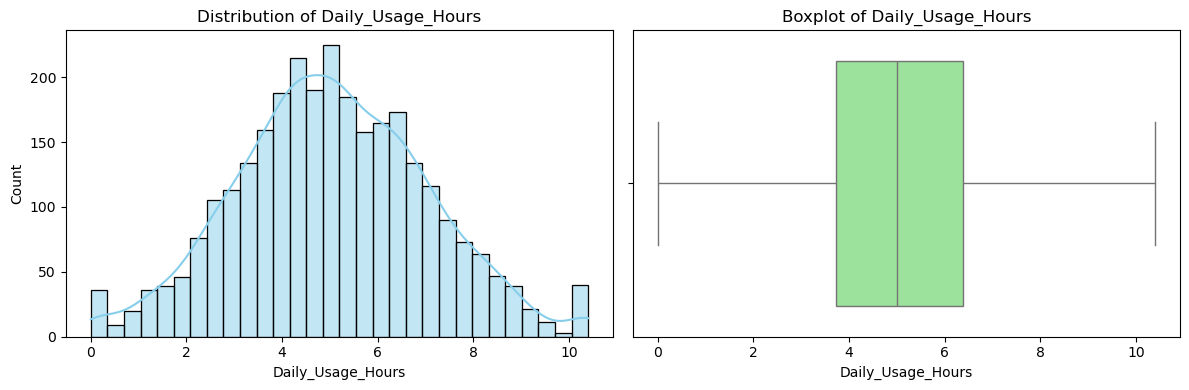

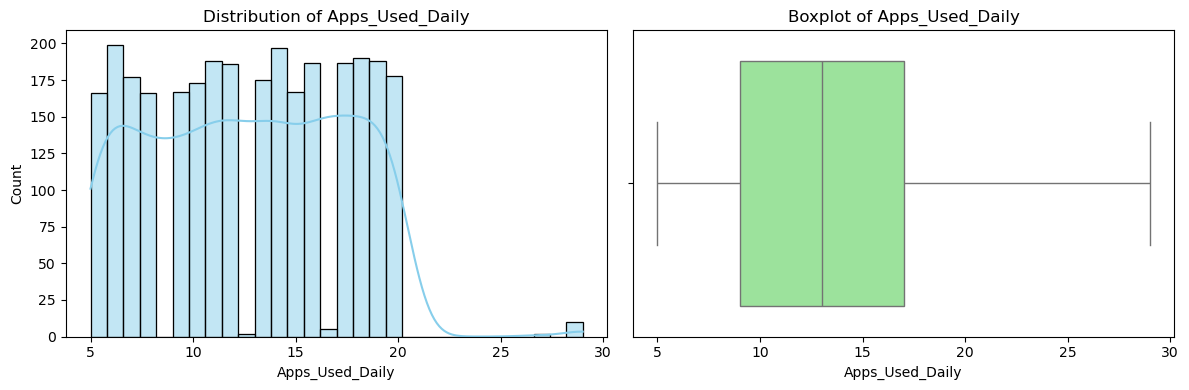

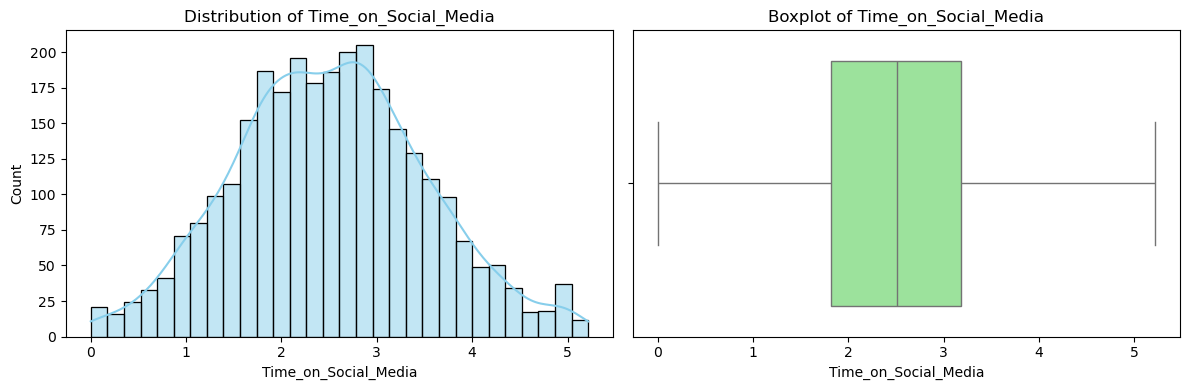

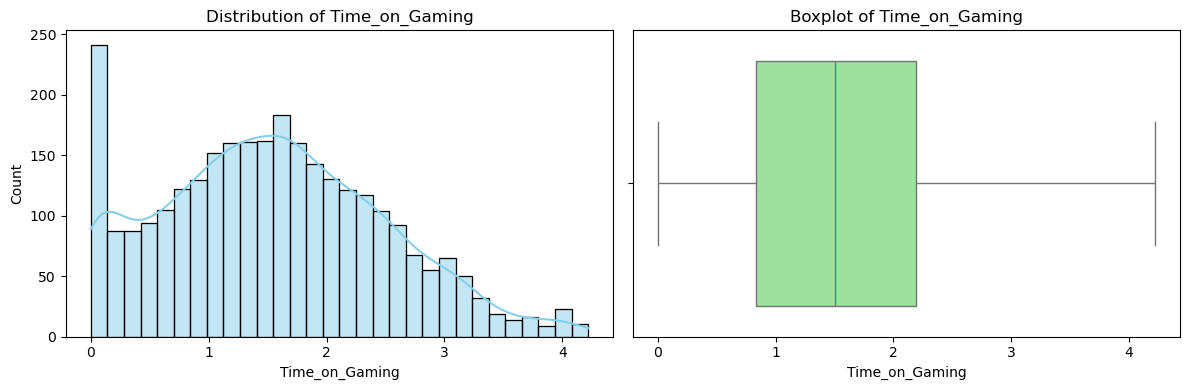

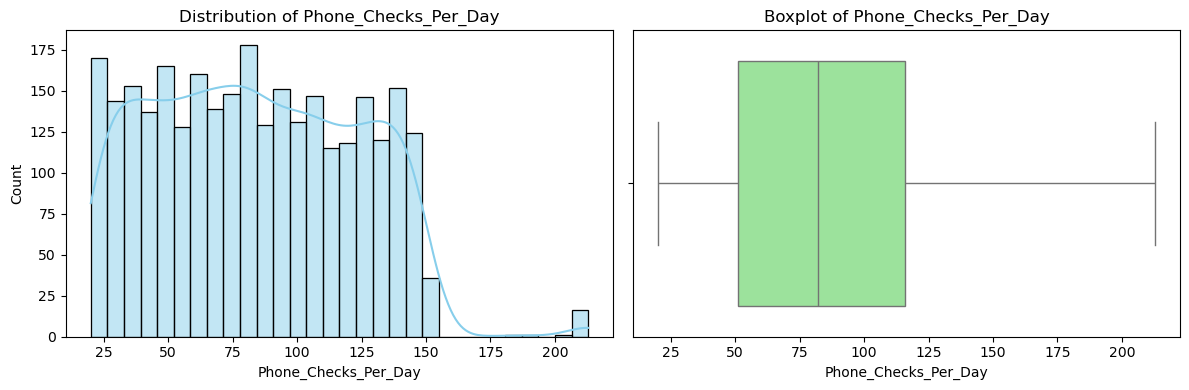

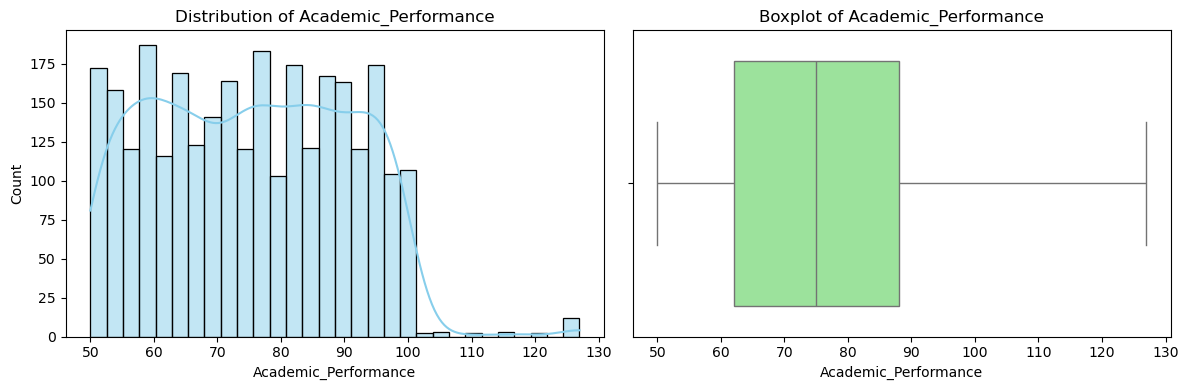

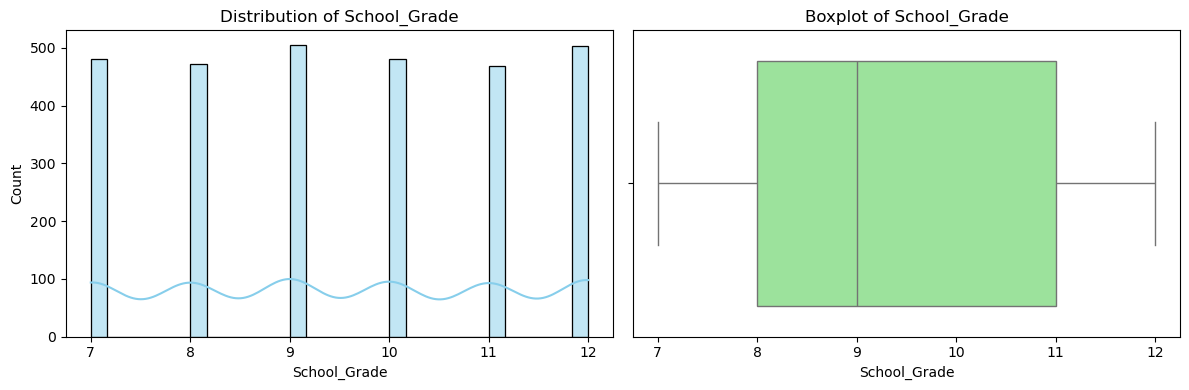

In [9]:
# Corrected list of features
features = [
    "Daily_Usage_Hours", "Apps_Used_Daily",
    "Time_on_Social_Media", "Time_on_Gaming", "Phone_Checks_Per_Day",
    "Academic_Performance", "School_Grade"
]

# plot for each feature
for col in features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram + KDE
    sns.histplot(df[col], kde=True, ax=axes[0], bins=30, color="skyblue")
    axes[0].set_title(f"Distribution of {col}")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

In [10]:
import tabulate
def mad_outlier_caps(df, cols, k=3.5):
    summary = {}
    df_out = df.copy()
    for c in cols:
        x = df_out[c].values.astype(float)
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med)) + 1e-9
        lower = med - k * 1.4826 * mad
        upper = med + k * 1.4826 * mad
        
        # Count outliers
        outliers = ((x < lower) | (x > upper)).sum()
        summary[c] = {
            "median": med,
            "mad": mad,
            "lower_cap": lower,
            "upper_cap": upper,
            "outliers_detected": int(outliers)
        }
        
        # Winsorize
        df_out[c] = np.clip(x, lower, upper)
    return df_out, pd.DataFrame(summary).T
  
cols_to_check = [
    "Daily_Usage_Hours", "Sleep_Hours", "Apps_Used_Daily", 
    "Time_on_Social_Media", "Time_on_Gaming", "Phone_Checks_Per_Day"
]

df_winsor, outlier_summary = mad_outlier_caps(df, cols_to_check)

print(tabulate.tabulate(outlier_summary, headers="keys", tablefmt="pretty"))


+----------------------+--------------------+--------------------+---------------------+--------------------+-------------------+
|                      |       median       |        mad         |      lower_cap      |     upper_cap      | outliers_detected |
+----------------------+--------------------+--------------------+---------------------+--------------------+-------------------+
|  Daily_Usage_Hours   | 4.998915437929382  | 1.355409557915019  | -2.034440299047443  | 12.032271174906207 |        0.0        |
|     Sleep_Hours      | 6.506403583371894  | 1.0228825431766864 | 1.1985637785737504  | 11.814243388170038 |        0.0        |
|   Apps_Used_Daily    |        13.0        |    4.000000001     |  -7.7564000051891   |  33.7564000051891  |        0.0        |
| Time_on_Social_Media | 2.5124615040954756 | 0.6784588809317625 | -1.0081294749475331 | 6.033052483138484  |        0.0        |
|    Time_on_Gaming    | 1.5036165743933985 | 0.674604615441002  | -1.996974235591505  | 5

In [11]:
import pandas as pd
import numpy as np
import tabulate

def cap_outliers_mad(df, cols, k=3.5):
    """
    Identifies outliers using the MAD method and caps them at the upper/lower bounds.
    This process is also known as Winsorization.
    """
    summary = {}
    df_capped = df.copy()

    for c in cols:
        # Ensure column is numeric
        x = df_capped[c].astype(float)
        
        # Calculate median and MAD
        median = np.nanmedian(x)
        # Add a small epsilon to avoid division by zero if MAD is 0
        mad = np.nanmedian(np.abs(x - median)) + 1e-9 
        
        # Calculate the robust z-score and the upper/lower bounds
        # The constant 1.4826 makes MAD comparable to the standard deviation
        lower_bound = median - k * 1.4826 * mad
        upper_bound = median + k * 1.4826 * mad
        
        # Count outliers
        outliers_count = ((x < lower_bound) | (x > upper_bound)).sum()
        
        # Store summary statistics
        summary[c] = {
            "median": median,
            "mad": mad,
            "lower_cap": lower_bound,
            "upper_cap": upper_bound,
            "outliers_capped": int(outliers_count)
        }
        
        # Cap the outliers using np.clip
        df_capped[c] = np.clip(x, lower_bound, upper_bound)
        
    summary_df = pd.DataFrame(summary).T
    return df_capped, summary_df

# Features to check
features_to_cap = [
    "Daily_Usage_Hours",
    "Apps_Used_Daily",
    "Time_on_Social_Media",
    "Time_on_Gaming",
    "Phone_Checks_Per_Day",
    "Academic_Performance"
]

# Apply the capping function
df_capped, cap_summary = cap_outliers_mad(df, features_to_cap)

# Show summary table
print("Outlier Capping Summary (MAD method):")
print(tabulate.tabulate(cap_summary, headers="keys", tablefmt="pretty"))

# You can now use df_capped for your next steps

Outlier Capping Summary (MAD method):
+----------------------+--------------------+--------------------+---------------------+--------------------+-----------------+
|                      |       median       |        mad         |      lower_cap      |     upper_cap      | outliers_capped |
+----------------------+--------------------+--------------------+---------------------+--------------------+-----------------+
|  Daily_Usage_Hours   | 4.998915437929382  | 1.355409557915019  | -2.034440299047443  | 12.032271174906207 |       0.0       |
|   Apps_Used_Daily    |        13.0        |    4.000000001     |  -7.7564000051891   |  33.7564000051891  |       0.0       |
| Time_on_Social_Media | 2.5124615040954756 | 0.6784588809317625 | -1.0081294749475331 | 6.033052483138484  |       0.0       |
|    Time_on_Gaming    | 1.5036165743933985 | 0.674604615441002  | -1.996974235591505  | 5.004207384378302  |       0.0       |
| Phone_Checks_Per_Day |        82.0        |    32.000000001    |

Outlier Handling Summary:
                         median        mad  outliers_handled
Daily_Usage_Hours      4.998915   2.009530               0.0
Apps_Used_Daily       13.000000   5.930400               0.0
Time_on_Social_Media   2.512462   1.005883               0.0
Time_on_Gaming         1.503617   1.000169               0.0
Phone_Checks_Per_Day  82.000000  47.443200               0.0
Academic_Performance  75.000000  19.273800               0.0

--- Visualizing Before vs. After ---


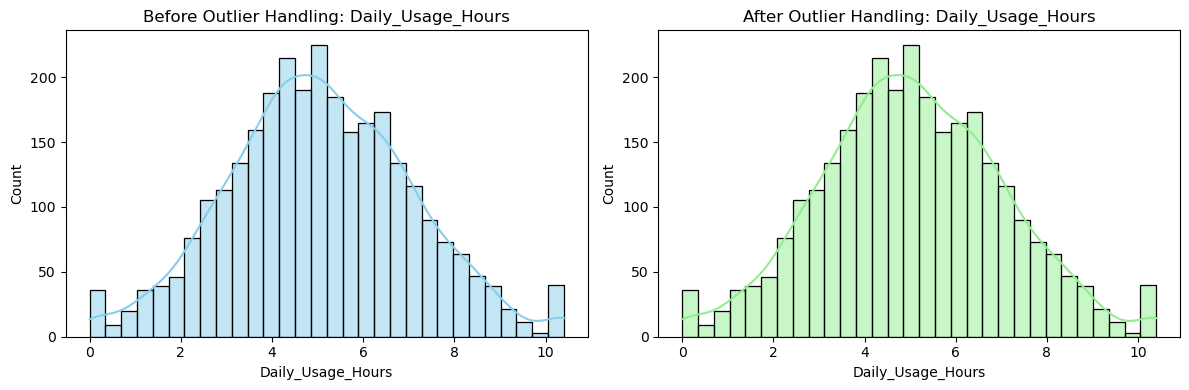

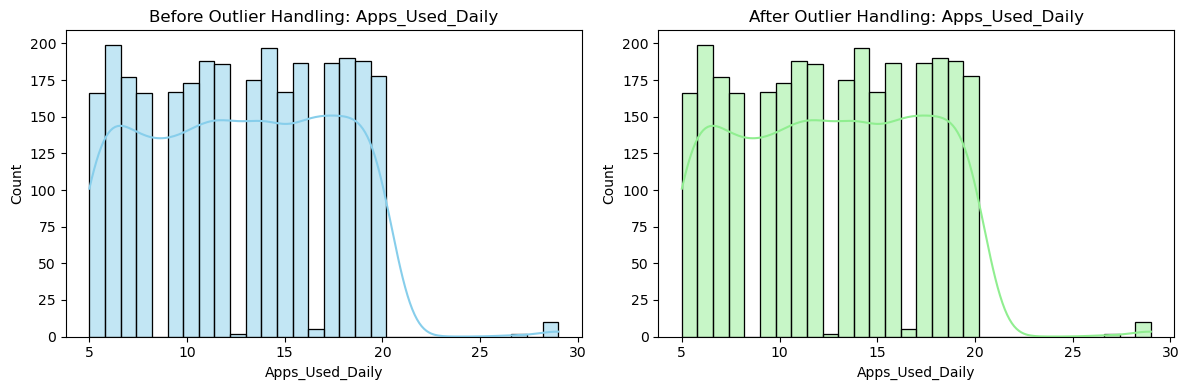

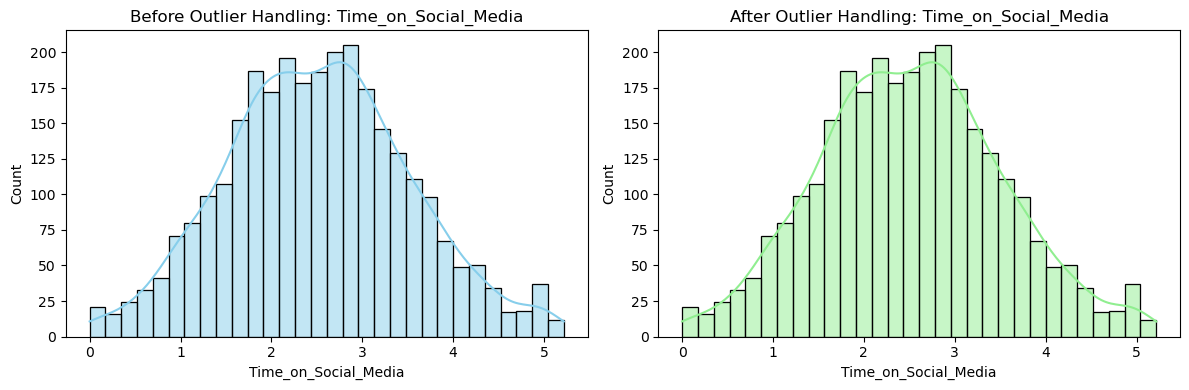

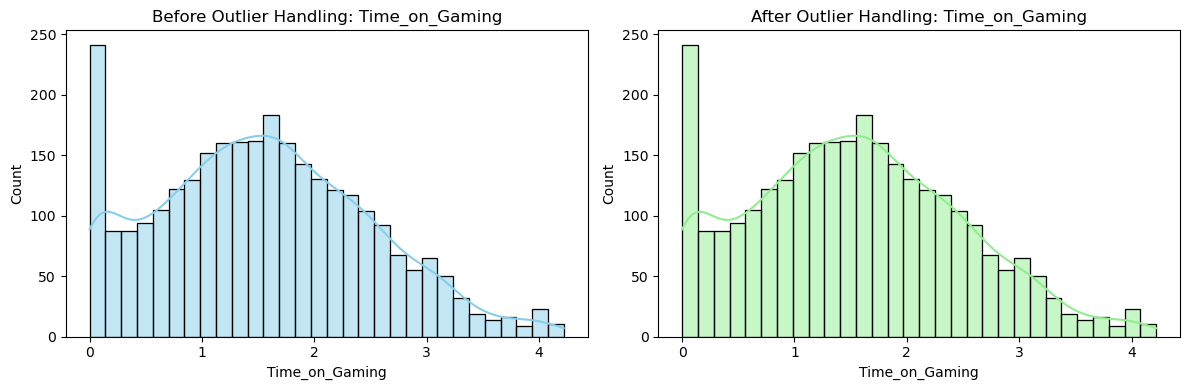

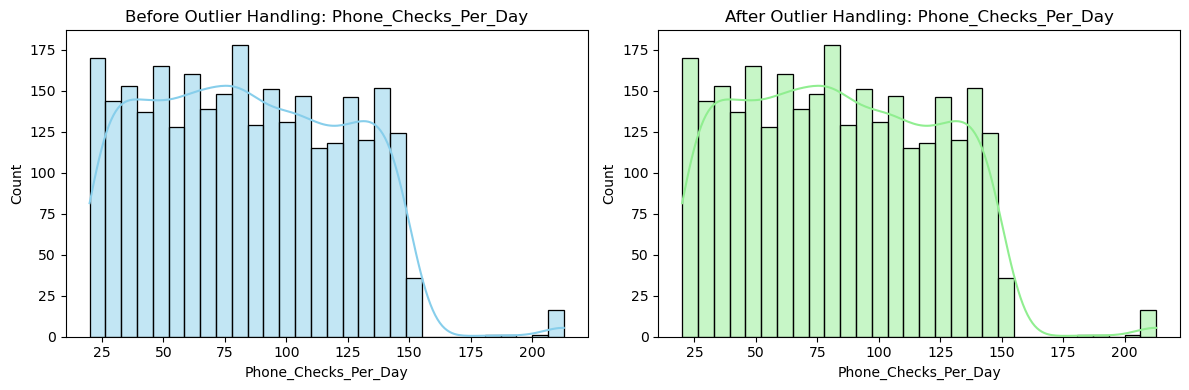

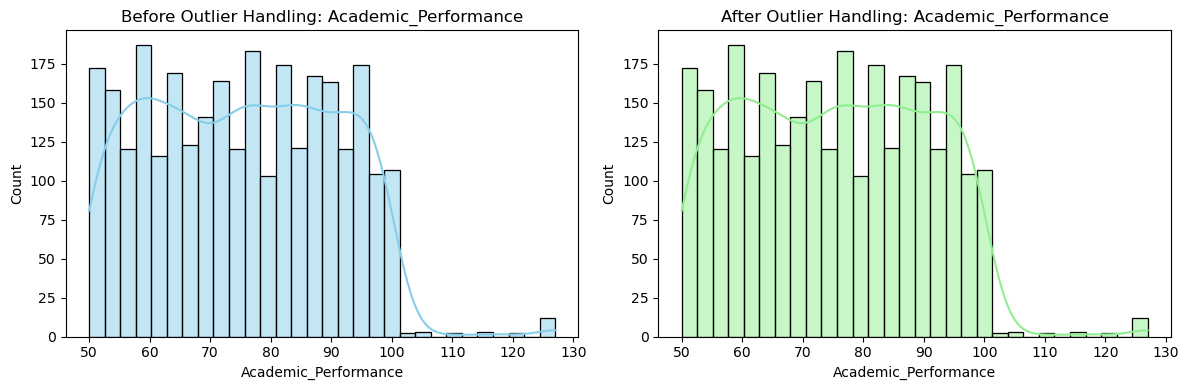

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your original dataframe 'df' is loaded correctly before this block
# For example: df = pd.read_csv("teen_phone_addiction_dataset_noisy.csv")
# ... plus any other initial cleaning you did ...

# --- PART 1: The Outlier Handling Function and Call (This creates df_clean) ---

# The full function that returns BOTH the DataFrame and the summary
def handle_outliers_mad(df, cols, k=3.5):
    summary = {}
    df_out = df.copy()
    
    for col in cols:
        med = df_out[col].median()
        mad = 1.4826 * np.median(np.abs(df_out[col] - med))
        
        # Outlier mask
        outlier_mask = np.abs(df_out[col] - med) > (k * mad)
        outlier_count = outlier_mask.sum()
        
        # Replace outliers with median
        df_out.loc[outlier_mask, col] = med
        
        # Save summary
        summary[col] = {
            "median": med,
            "mad": mad,
            "outliers_handled": int(outlier_count)
        }
        
    summary_df = pd.DataFrame(summary).T
    # This return statement is now correct for your call
    return df_out, summary_df

# List of features to clean
features_to_clean = [
    "Daily_Usage_Hours", "Apps_Used_Daily", "Time_on_Social_Media",
    "Time_on_Gaming", "Phone_Checks_Per_Day", "Academic_Performance"
]

# Apply the function to create df_clean
# This call now works because the function returns two items
df_clean, mad_summary = handle_outliers_mad(df, features_to_clean)
print("Outlier Handling Summary:")
print(mad_summary)


# --- PART 2: Your Visualization Code (This will now run without error) ---
print("\n--- Visualizing Before vs. After ---")

for col in features_to_clean:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Before cleaning
    sns.histplot(df[col], kde=True, bins=30, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Before Outlier Handling: {col}")

    # After cleaning
    sns.histplot(df_clean[col], kde=True, bins=30, color="lightgreen", ax=axes[1])
    axes[1].set_title(f"After Outlier Handling: {col}")

    plt.tight_layout()
    plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler  # <-- Important: Import the scaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- Step 1: Use the CLEANED data ---
# This is the most important change!
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# --- Step 2: Scale the Features ---
# This ensures all features are on a level playing field
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 3: Train-Test Split ---
# We use the SCALED data now
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# --- Step 4: Train the Model ---
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # Uses all available CPU cores to speed up training
)
rf_reg.fit(X_train, y_train)

# --- Step 5: Make Predictions and Evaluate ---
y_pred = rf_reg.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("✅ Random Forest Regressor implemented successfully!")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

✅ Random Forest Regressor implemented successfully!
RMSE (Root Mean Squared Error): 0.800
R² Score: 0.731


📌 Top 10 Features Influencing Addiction Level:
                 Feature  Importance
3      Daily_Usage_Hours    0.403767
15  Time_on_Social_Media    0.131721
16        Time_on_Gaming    0.108284
14       Apps_Used_Daily    0.106497
13  Phone_Checks_Per_Day    0.068255
4            Sleep_Hours    0.066310
17     Time_on_Education    0.015003
19   Weekend_Usage_Hours    0.010195
7         Exercise_Hours    0.010091
5   Academic_Performance    0.009889


C:\Users\deogh\AppData\Local\Temp\ipykernel_7104\3284877277.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature", palette="viridis")


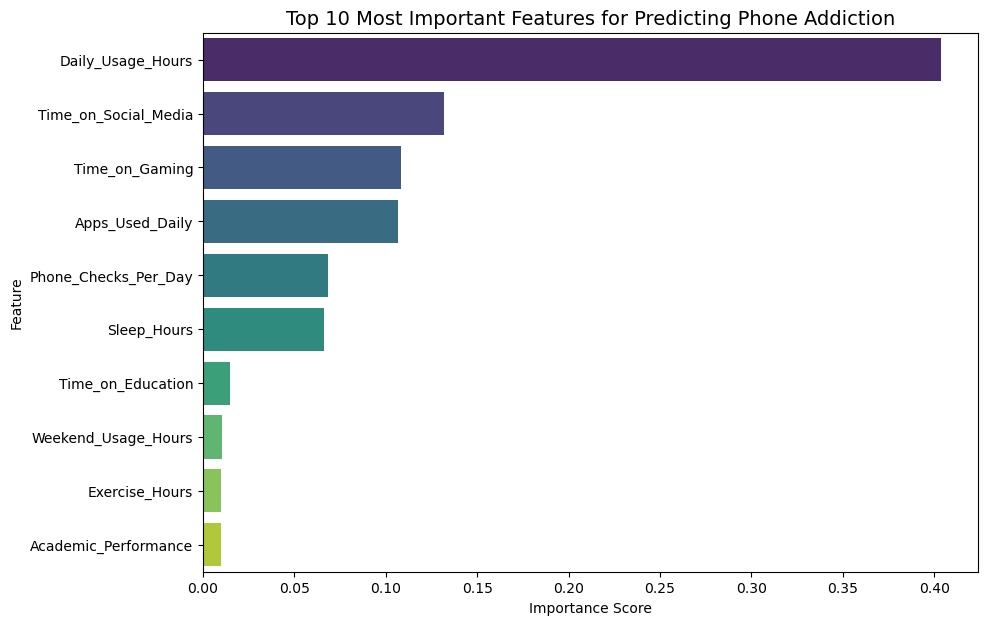

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Feature Importance Extraction ---
# Get the importance scores from the trained model
importances = rf_reg.feature_importances_

# Create a DataFrame to view the feature importances clearly
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False) # Sort to find the most important features

print("📌 Top 10 Features Influencing Addiction Level:")
print(feat_imp.head(10))

# --- Visualization ---
# Create the bar plot to visualize the top features
plt.figure(figsize=(10, 7)) # Made the plot a bit bigger for clarity
sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Most Important Features for Predicting Phone Addiction", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [15]:
import numpy as np

# === Add train/test flag ===
df["is_train"] = np.random.uniform(0, 1, len(df)) <= 0.75

# === Create train and test sets ===
train, test = df[df["is_train"] == True], df[df["is_train"] == False]

# Use X_test, which was created by train_test_split
print(f"No. of observations in the testing dataset: {len(X_test)}")
# You can also use y_test
print(f"No. of observations in the testing dataset: {len(y_test)}")
# === Features (excluding target and helper column) ===
f = df.columns.drop(["Addiction_Level", "is_train"])
print("Features used for training:", f.tolist())


No. of observations in the testing dataset: 728
No. of observations in the testing dataset: 728
Features used for training: ['Age', 'Location', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance', 'Social_Interactions', 'Exercise_Hours', 'Anxiety_Level', 'Depression_Level', 'Self_Esteem', 'Parental_Control', 'Screen_Time_Before_Bed', 'Phone_Checks_Per_Day', 'Apps_Used_Daily', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education', 'Family_Communication', 'Weekend_Usage_Hours', 'Gender_Male', 'Gender_Other', 'Phone_Usage_Purpose_Education', 'Phone_Usage_Purpose_Gaming', 'Phone_Usage_Purpose_Other', 'Phone_Usage_Purpose_Social Media']


In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# =============================
# Step 1: Use the CLEANED Data and Split It
# =============================
# CRITICAL: Use the df_clean DataFrame from your previous steps
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# CRITICAL: Split the data BEFORE doing any training or tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# =============================
# Step 2: Create a Pipeline
# =============================
# This pipeline will first scale the data, then apply the KNN model
pipe = Pipeline([
    ("standardizer", StandardScaler()),
    ("knn", KNeighborsRegressor()) # We define the model here but tune it below
])

# =============================
# Step 3: Define the Hyperparameter Search Space
# =============================
# We'll search for the best number of neighbors, weighting method, and distance metric
search_space = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # 1 = Manhattan distance, 2 = Euclidean distance
}

# =============================
# Step 4: Run the Grid Search on the TRAINING Data
# =============================
# GridSearchCV will find the best combination of parameters using cross-validation
# Importantly, we only fit it on the TRAINING data
grid_search = GridSearchCV(pipe, search_space, cv=5, scoring="r2", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# =============================
# Step 5: Show the Best Parameters Found
# =============================
print("✅ Grid Search Complete!")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation R² Score: {grid_search.best_score_:.3f}")

# =============================
# Step 6: Evaluate the FINAL Model on the TEST Data
# =============================
# Now we use the best model found by the search to make predictions on the UNSEEN test data
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test)

# Calculate the final, true performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Performance on Unseen Test Data ---")
print(f"Final RMSE: {rmse:.3f}")
print(f"Final R² Score: {r2:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Grid Search Complete!
Best Parameters Found: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}
Best Cross-Validation R² Score: 0.422

--- Final Model Performance on Unseen Test Data ---
Final RMSE: 1.176
Final R² Score: 0.418


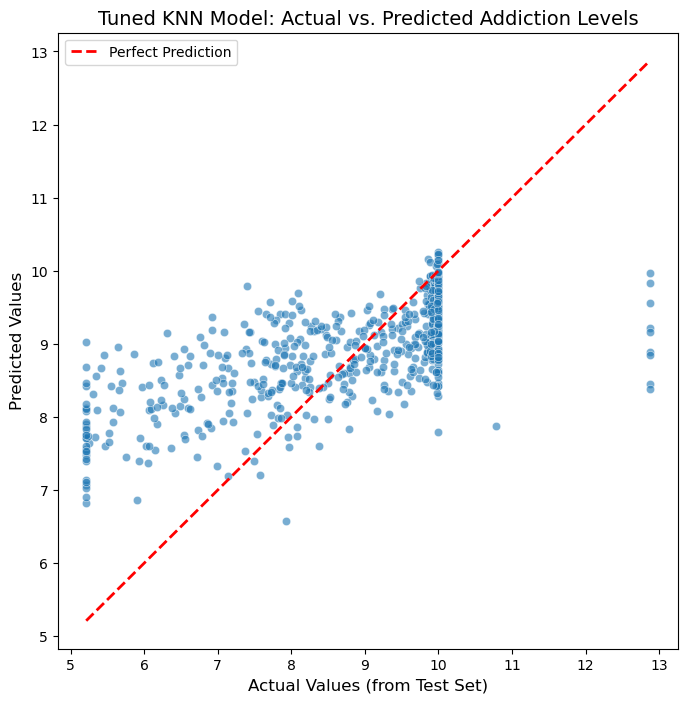

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create the Prediction Error Plot ---

# The variable 'y_pred' was created in the last step by the GridSearchCV model
# The variable 'y_test' was also created in that step during the train_test_split

plt.figure(figsize=(8, 8))

# Corrected line: Use y_pred, which holds your latest KNN predictions
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Add a line for perfect predictions (where Actual equals Predicted)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction')

# Add titles and labels for clarity
plt.title('Tuned KNN Model: Actual vs. Predicted Addiction Levels', fontsize=14)
plt.xlabel('Actual Values (from Test Set)', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.show()


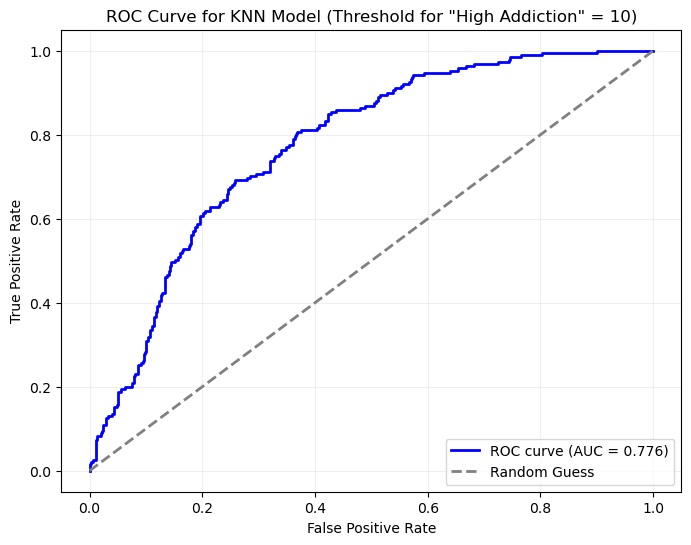

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Step 1: Define a Binary Classification Problem ---
# We'll set a threshold to create two classes. For example, any user with an
# addiction score of 10 or more will be considered "High Addiction" (Class 1).
threshold = 10

# Convert the actual scores (y_test) into binary classes (0 or 1)
y_test_binary = (y_test >= threshold).astype(int)

# --- Step 2: Get Prediction Scores for the ROC Curve ---
# The ROC curve works best with the raw prediction scores. Since your model
# predicts the addiction level, higher scores indicate a higher chance
# of being in the "High Addiction" class. We can use these directly.
y_pred_scores = y_pred

# --- Step 3: Calculate the ROC Curve and AUC Score ---
# This calculates the points on the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_scores)

# This calculates the Area Under the Curve (a single score for performance)
auc = roc_auc_score(y_test_binary, y_pred_scores)

# --- Step 4: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess') # Line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for KNN Model (Threshold for "High Addiction" = {threshold})')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# =============================
# Step 1: Use the CLEANED Data
# =============================
# CRITICAL: Ensure you are using the cleaned DataFrame
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# =============================
# Step 2: Convert the Target to a Binary Classification
# =============================
# Create two classes: "High Addiction" (1) and "Not High Addiction" (0)
threshold = 10
y_class = (y >= threshold).astype(int)

# Optional: Check if the classes are balanced
print("Class Distribution:")
print(pd.Series(y_class).value_counts())
print("-" * 30)

# =============================
# Step 3: Define the Pipeline
# =============================
# A pipeline ensures the data is scaled correctly during each cross-validation fold
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    # NOTE: We are using a fixed k=10 here. For best results, this should be tuned.
    ("knn", KNeighborsClassifier(n_neighbors=10, metric="euclidean"))
])

# =============================
# Step 4: Perform Cross-Validation
# =============================
# Get robust estimates for recall and precision using 5-fold cross-validation
recall_scores = cross_val_score(pipeline, X, y_class, cv=5, scoring="recall")
precision_scores = cross_val_score(pipeline, X, y_class, cv=5, scoring="precision")

print("✅ Cross-Validation Results (5-fold)")
print(f"Recall:    Mean = {np.mean(recall_scores):.3f} | Scores = {np.round(recall_scores, 3)}")
print(f"Precision: Mean = {np.mean(precision_scores):.3f} | Scores = {np.round(precision_scores, 3)}")

Class Distribution:
Addiction_Level
0    2154
1     756
Name: count, dtype: int64
------------------------------
✅ Cross-Validation Results (5-fold)
Recall:    Mean = 0.098 | Scores = [0.099 0.073 0.139 0.066 0.112]
Precision: Mean = 0.574 | Scores = [0.577 0.458 0.75  0.5   0.586]


In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("--- Tuned Decision Tree Model ---")

# Define the hyperparameter search space
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Initialize the Decision Tree Regressor
dt_tuner = DecisionTreeRegressor(random_state=42)

# Set up GridSearchCV to find the best parameters
grid_search_dt = GridSearchCV(estimator=dt_tuner, param_grid=param_grid,
                              cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
# (This assumes X_train and y_train are already created from a previous step)
grid_search_dt.fit(X_train, y_train)

# Get the best model found by the search
best_dt_model = grid_search_dt.best_estimator_

# Make predictions with the best model on the test set
y_pred_best_dt = best_dt_model.predict(X_test)

# Evaluate the tuned model
rmse_best_dt = np.sqrt(mean_squared_error(y_test, y_pred_best_dt))
r2_best_dt = r2_score(y_test, y_pred_best_dt)

print("\n✅ Tuned Decision Tree -> Best Parameters:", grid_search_dt.best_params_)
print(f"✅ Tuned Decision Tree -> RMSE: {rmse_best_dt:.3f}, R² Score: {r2_best_dt:.3f}")

--- Tuned Decision Tree Model ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Tuned Decision Tree -> Best Parameters: {'max_depth': 15, 'min_samples_leaf': 6}
✅ Tuned Decision Tree -> RMSE: 1.032, R² Score: 0.552


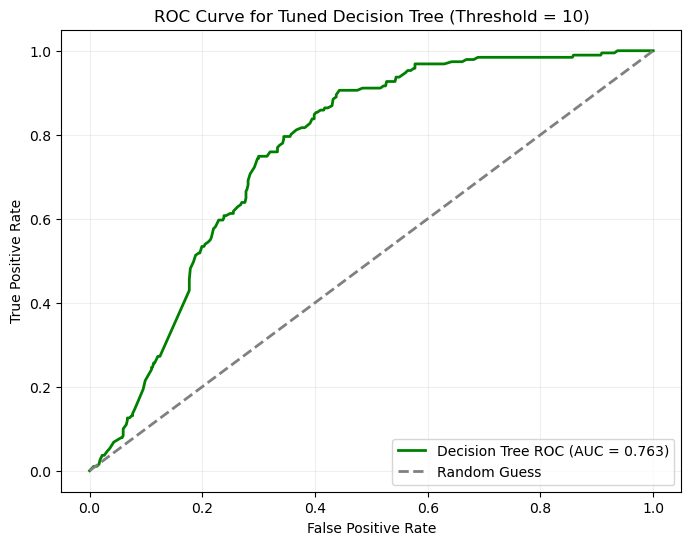

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Define the Binary Classification Problem ---
# We use the same threshold to create the classes
threshold = 10
y_test_binary = (y_test >= threshold).astype(int)

# --- Step 2: Get Prediction Scores ---
# Use the prediction scores from the tuned Decision Tree model
y_pred_scores_dt = y_pred_best_dt

# --- Step 3: Calculate ROC and AUC ---
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_scores_dt)
auc = roc_auc_score(y_test_binary, y_pred_scores_dt)

# --- Step 4: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Decision Tree ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Tuned Decision Tree (Threshold = {threshold})')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

--- Logistic Regression Model ---
✅ Accuracy: 0.721

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       539
           1       0.44      0.29      0.35       189

    accuracy                           0.72       728
   macro avg       0.61      0.58      0.58       728
weighted avg       0.69      0.72      0.70       728


--- Confusion Matrix ---


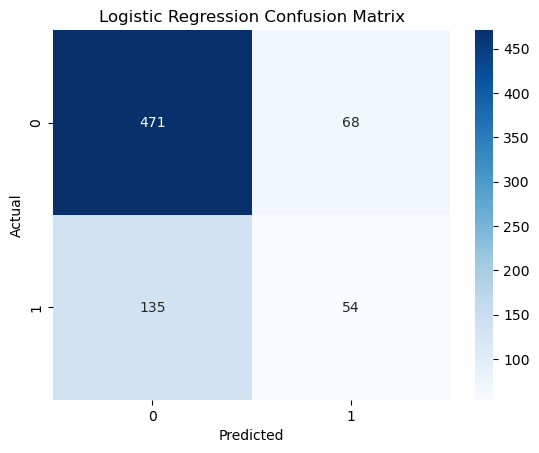

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Step 1: Prepare Data for Classification ---

# Use the final cleaned DataFrame from previous steps
# This assumes 'df_clean' and 'X_scaled' are your fully processed data
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# Create the binary target variable (y_class)
# We'll define "High Addiction" as any score of 10 or greater
threshold = 10
y_class = (y >= threshold).astype(int) # 1 for High Addiction, 0 for Not

# Split the data into training and testing sets for our classification task
# We use the scaled features and the new y_class
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_scaled, y_class, test_size=0.25, random_state=42, stratify=y_class
)

# --- Step 2: Implement and Evaluate Logistic Regression ---

print("--- Logistic Regression Model ---")

# Initialize and train the model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_class)

# Make predictions on the test set
y_pred_log = log_reg.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test_class, y_pred_log)
print(f"✅ Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_log))

# Visualize the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_class, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

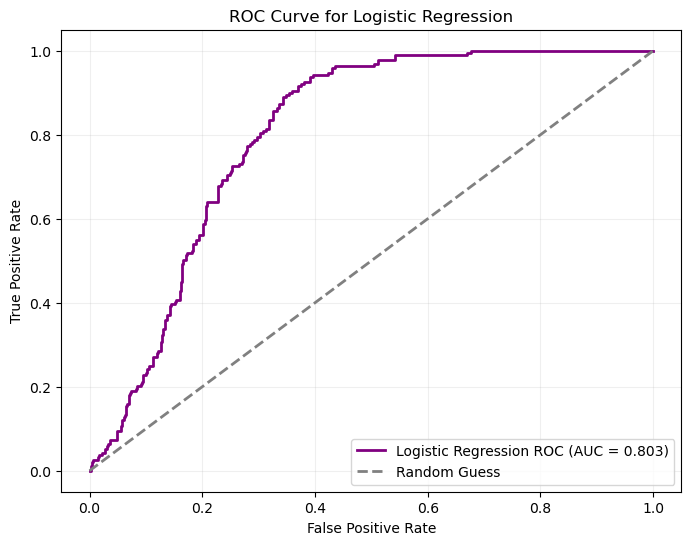

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Get Prediction Probabilities ---
# We need the probability of the "positive" class (1, or "High Addiction")
# The .predict_proba() method gives us this. [:, 1] selects the second column.
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# --- Step 2: Calculate ROC and AUC ---
# This calculates the points on the ROC curve
fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba)

# This calculates the Area Under the Curve (a single score for performance)
auc = roc_auc_score(y_test_class, y_pred_proba)

# --- Step 3: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Logistic Regression ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

--- Naive Bayes Model ---
✅ Accuracy: 0.740

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       539
           1       0.50      0.25      0.33       189

    accuracy                           0.74       728
   macro avg       0.64      0.58      0.59       728
weighted avg       0.70      0.74      0.71       728


--- Confusion Matrix ---


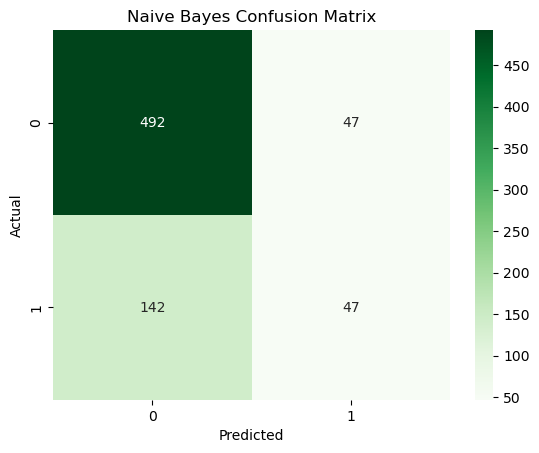

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("--- Naive Bayes Model ---")

# --- Step 1: Initialize and Train the Model ---
# We use GaussianNB, a version of Naive Bayes suitable for continuous features
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train_class)

# --- Step 2: Make Predictions ---
# Predict the classes for the test set
y_pred_nb = nb_clf.predict(X_test)

# --- Step 3: Evaluate the Model ---
accuracy_nb = accuracy_score(y_test_class, y_pred_nb)
print(f"✅ Accuracy: {accuracy_nb:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_nb))

# --- Step 4: Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm_nb = confusion_matrix(y_test_class, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

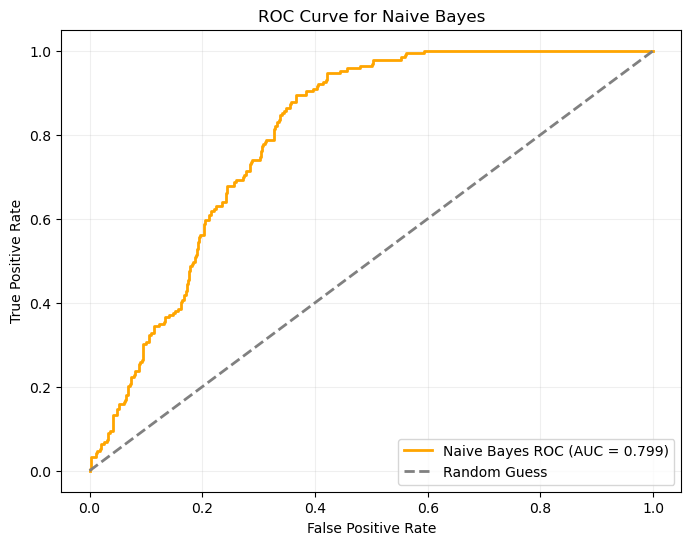

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Get Prediction Probabilities ---
# We get the probabilities for the positive class (1) from the trained Naive Bayes model
y_pred_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

# --- Step 2: Calculate ROC and AUC ---
fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba_nb)
auc_nb = roc_auc_score(y_test_class, y_pred_proba_nb)

# --- Step 3: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Naive Bayes ROC (AUC = {auc_nb:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()